## 1.환경설정

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important;}</style>"))
%matplotlib inline

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (12,8)  #시각화 figure default 설정
mpl.rcParams['font.family'] = 'NanumGothic' #폰트 디폴트 설정
mpl.rcParams['font.size'] = 10    #폰트 사이즈 디폴트 설정
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷
pd.options.display.float_format = '{:.0f}'.format # 넘파이 과학적 표기 제거

## 2.데이터 로드

### 2.1 경로 설정

### 2.2 로컬 파일 로드

In [3]:
df_shop = pd.read_csv("H:\내 드라이브\jeju\제주도_상권정보.csv", encoding = "cp949")
df_facility = pd.read_csv("H:\내 드라이브\jeju\제주도_관광편의시설현황_2022.csv", encoding = "cp949")
df_card = pd.read_csv("H:\내 드라이브\jeju\제주도_유동인구_카드매출액_2018.csv", encoding = "cp949")
df_chinese = pd.read_csv("H:\내 드라이브\jeju\중국인_업종별_이용금액_2018.csv", encoding = "cp949")
df_wifi = pd.read_csv("H:\내 드라이브\jeju\외국인유동인구_와이파이이용_2018.csv", encoding = "cp949")

## 3.데이터 전처리

### 3.1 제주도 유동인구 카드매출액(2018년)

#### 3.1.1 제주도 카드매출 전처리

In [4]:
# df_card["지역명"] = "제주특별자치도" + " " + df_card["시도명"] + " " + df_card["읍면동명"]

In [5]:
df_card_new = df_card.groupby(["읍면동명", "년월", "업종명"])[["이용자수", "이용금액", "방문인구"]].agg("sum").reset_index().copy()

In [6]:
df_card_new.head()

읍면동명          년월                업종명  이용자수      이용금액    방문인구
0  건입동  2018-01-01        과실 및 채소 소매업    65   7802800 4938897
1  건입동  2018-01-01  관광 민예품 및 선물용품 소매업   142   3569450 4938897
2  건입동  2018-01-01        기타 외국식 음식점업   226   7633360 4938897
3  건입동  2018-01-01             기타 주점업   109  22890000 4938897
4  건입동  2018-01-01      기타음식료품위주종합소매업    38   6516550 4938897

In [7]:
df_card_new["1인당지출"] = df_card_new["이용금액"] / df_card_new["이용자수"]

In [8]:
df_card_new["년월"] = df_card_new["년월"].str[:-3]

#### 3.1.2 제주도 지역별 지출 및 방문객 수 분포 및 구분

In [9]:
df_district = df_card_new.groupby("읍면동명").sum().reset_index()
df_district["1인당지출"] = df_district["이용금액"] / df_district["이용자수"]

In [10]:
df_district.sample()

읍면동명     이용자수          이용금액      방문인구  1인당지출
15  송산동  2723773  100290745684 434374874  36821

In [11]:
11944813957 / 310669

38448.68318692885

In [12]:
## 평균 1인당지출
mean_expenditure = np.mean(df_district['1인당지출'])
print("평균 1인당지출:", mean_expenditure)

## 평균 방문인구
mean_tourist = np.mean(df_district['방문인구'])
print("평균 방문인구:", mean_tourist)

평균 1인당지출: 35733.6410177536
평균 방문인구: 1807337969.3193033


In [13]:
## 평균 1인당지출과 평균 방문인구를 기준으로 High/Low 구분
def expenditure_segmentation(expenditure, mean_expenditure):
    if (expenditure >= mean_expenditure):
        return "높은 관광지출"
    elif (expenditure < mean_expenditure):
        return "낮은 관광지출"
    
def tourist_segmentation(tourist, mean_tourist):
    if (tourist >= mean_tourist):
        return "높은 방문객수"
    elif (tourist < mean_tourist):
        return "낮은 방문객수"

In [14]:
## 위에서 정의한 함수르 적용하여 지역 구분 필드 생성
df_district["관광지출_구분"] = df_district["1인당지출"].apply(lambda x: expenditure_segmentation(x, mean_expenditure))
df_district["방문객수_구분"] = df_district["방문인구"].apply(lambda x: tourist_segmentation(x, mean_tourist))

In [15]:
## 2개의 구분 필드를 결합하여 "지역_구분" 필드로 통합
df_district["지역_구분"] = df_district["관광지출_구분"] + " & " + df_district["방문객수_구분"]
df_district.head(3)

읍면동명    이용자수         이용금액       방문인구  1인당지출  관광지출_구분  방문객수_구분  \
0  건입동  637606  22837472311 1516734675  35818  높은 관광지출  낮은 방문객수   
1  구좌읍  801964  24672424016 1946041726  30765  낮은 관광지출  높은 방문객수   
2  남원읍  617808  26116645201 1682710331  42273  높은 관광지출  낮은 방문객수   

               지역_구분  
0  높은 관광지출 & 낮은 방문객수  
1  낮은 관광지출 & 높은 방문객수  
2  높은 관광지출 & 낮은 방문객수

In [16]:
# df_district.to_csv("제주도_지역별_연간방문객수_1인당지출.csv", index = False)

In [17]:
## "지역_구분"을 기준으로 그룹화하여 소속된 읍면동명 확인
df_district.groupby(["지역_구분", "읍면동명"])[["방문인구", "1인당지출"]].sum()

방문인구  1인당지출
지역_구분             읍면동명                  
낮은 관광지출 & 낮은 방문객수 대정읍  1402450560  32647
                  대천동  1130720804  26864
                  동홍동  1516297911  32851
                  삼도1동 1455991387  30550
                  삼양동   983827359  25303
                  서홍동   635625243  22379
                  외도동  1060109452  26968
                  우도면   205980081  24304
                  이호동   586353829  28364
                  천지동   485510672  35223
                  효돈동   240024140  27601
낮은 관광지출 & 높은 방문객수 구좌읍  1946041726  30765
                  노형동  6031387943  31720
                  성산읍  2226897809  33860
                  아라동  3103245604  21638
                  안덕면  2314658633  33957
                  애월읍  5597200967  34962
                  오라동  2630533234  35075
                  이도2동 6267381151  29791
                  일도2동 2528784477  33756
                  조천읍  3087423560  32559
                  화북동  1904236034  27754
높은 관광지출 & 낮은 방문객수 건입동  1516734675  35818
                  남원읍  1682710331  42273
                  도두동   660535341  38354
                  봉개동   658321867  38449
                  삼도2동 1271362494  42609
                  송산동   434374874  36821
                  영천동   555704091  55658
                  용담1동  925972239  39207
                  이도1동 1763670245  41653
                  일도1동  611658177  46376
                  정방동   927530860  37971
                  중문동  1301941336  40258
                  중앙동  1050344784  37971
                  추자면   129501133  40235
                  표선면  1490532873  38919
                  한경면   651516174  39160
높은 관광지출 & 높은 방문객수 대륜동  2032433025  37854
                  연동   6238260113  47008
                  예래동  1808471748  55906
                  용담2동 2320021949  48561
                  한림읍  2343251776  36595

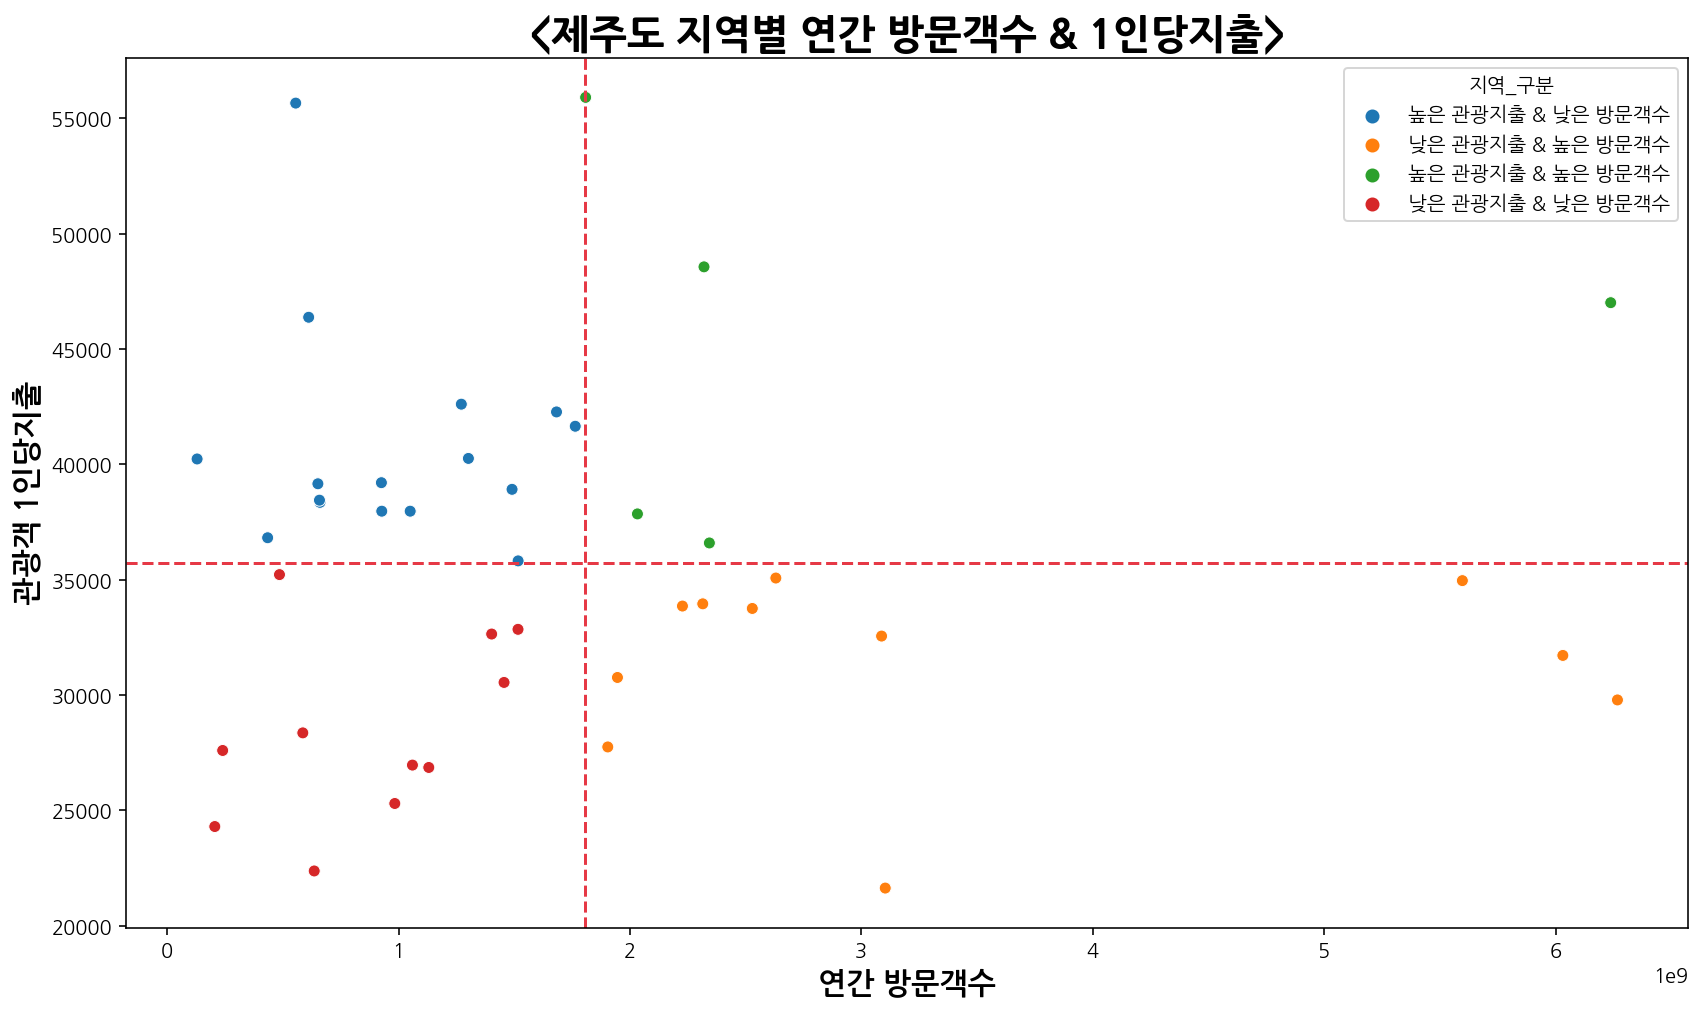

In [18]:
## 제주도 지역별 연간 관광객수와 1인당 지출을 기준으로 산점도 시각화 
## 평균 지출액과 평균 방문객수를 기준으로 4개의 영역으로 구분
plt.figure(figsize = (14, 8))
sns.scatterplot(x = df_district["방문인구"], y = df_district["1인당지출"], hue = df_district["지역_구분"])
plt.axhline(y = mean_expenditure, linestyle = "--", color = "#e63946")
plt.axvline(x = mean_tourist, linestyle = "--", color = "#e63946")
plt.xlabel("연간 방문객수", fontsize = 15, fontweight = "semibold")
plt.ylabel("관광객 1인당지출", fontsize = 15, fontweight = "semibold")
plt.title("<제주도 지역별 연간 방문객수 & 1인당지출>",fontsize = 20, fontweight = "bold")
plt.show()

#### 3.1.3 분포 지도시각화

In [19]:
df_jeju_map = pd.read_csv("H:\내 드라이브\jeju\제주도_지역별_연간방문객수_1인당지출.csv", encoding = "utf-8-sig")
df_jeju_map.head(2)
# df_jeju_map = df_jeju_map[["지역명", "지역_구분"]]
# df_jeju_map.head(2)

지역명    이용자수         이용금액       방문인구  1인당지출  관광지출_구분  방문객수_구분  \
0  제주특별자치도 서귀포시 남원읍  617808  26116645201 1682710331  42273  높은 관광지출  낮은 방문객수   
1  제주특별자치도 서귀포시 대륜동  878040  33236919978 2032433025  37854  높은 관광지출  높은 방문객수   

               지역_구분  
0  높은 관광지출 & 낮은 방문객수  
1  높은 관광지출 & 높은 방문객수

In [20]:
import folium
import requests
import json
import folium.plugins

# 서울 행정구역 json raw파일(githubcontent)
# r = requests.get('https://raw.githubusercontent.com/vuski/admdongkor/master/ver20230101/HangJeongDong_ver20230101.geojson')
r = requests.get('https://raw.githubusercontent.com/raqoon886/Local_HangJeongDong/master/hangjeongdong_%EC%A0%9C%EC%A3%BC%ED%8A%B9%EB%B3%84%EC%9E%90%EC%B9%98%EB%8F%84.geojson')
c = r.content
jeju_geo = json.loads(c)

In [21]:
# jeju_geo

In [29]:
m = folium.Map(
    location=[33.361417, 126.529417],
    width=750, height=500,
    zoom_start=10, 
    tiles='cartodbpositron',
    min_zoom=10,
    max_zoom=10, 
    zoom_control = False
)

folium.GeoJson(
    jeju_geo,
    name='지역명'
).add_to(m)

folium.Choropleth(
            geo_data= jeju_geo,
            data=df_jeju_map,
            columns = ["지역명", "1인당지출"],
            fill_color='RdBu_r',
            line_color="Black", 
            fill_opacity=0.8,
            line_opacity=1.0,
            key_on='properties.adm_nm',
            legend_name='1인당지출').add_to(m) 

locations = list(zip(df_shop["위도"], df_shop["경도"]))[:20000]


cluster = folium.plugins.MarkerCluster(locations=locations)
m.add_child(cluster)

# for i in range(len(locations[:10000])):
#     folium.CircleMarker(location=locations[i],radius=1).add_to(m)

m

In [30]:
m = folium.Map(
    location=[33.361417, 126.529417],
    width=750, height=500,
    zoom_start=10, 
    tiles='cartodbpositron',
    min_zoom=10,
    max_zoom=10, 
    zoom_control = False
)

folium.GeoJson(
    jeju_geo,
    name='지역명'
).add_to(m)

folium.Choropleth(
            geo_data= jeju_geo,
            name = "지역별 연간방문객수",
            data=df_jeju_map,
            columns = ["지역명", "방문인구"],
            fill_color='RdBu_r', 
            line_color="Black", 
            fill_opacity=0.8,
            line_opacity=1.0,
            key_on='properties.adm_nm',
            legend_name='연간방문객수').add_to(m)
m 

In [24]:
# from folium.features import DivIcon
# import folium.plugins

# m = folium.plugins.DualMap(
#     location=[33.361417, 126.529417],
#     zoom_start=10, 
#     tiles='cartodbpositron',
#     min_zoom=10,
#     max_zoom=10, 
#     zoom_control = False
# )

# folium.GeoJson(
#     jeju_geo,
#     name='지역명'
# ).add_to(m)

# # 왼쪽 지도 - 지역별 방문객 1인당 지출"
# choropleth1 = folium.Choropleth(
#             geo_data= jeju_geo,
#             name = "지역별 방문객 1인당 지출",
#             data=df_jeju_map,
#             columns = ["지역명", "1인당지출"],
#             fill_color='RdBu', 
#             fill_opacity=0.8,
#             line_opacity=0.2,
#             key_on='properties.adm_nm',
#             legend_name='1인당지출').add_to(m.m1) 

# # 오른쪽 지도 - 지역별 연간방문객수

# choropleth2 = folium.Choropleth(
#             geo_data= jeju_geo,
#             name = "지역별 연간방문객수",
#             data=df_jeju_map,
#             columns = ["지역명", "방문인구"],
#             fill_color='RdBu', 
#             fill_opacity=0.8,
#             line_opacity=0.2,
#             key_on='properties.adm_nm',
#             legend_name='연간방문객수').add_to(m.m2) 

# m

### 3.2 제주도 상권 / 관광시설 데이터

In [25]:
# df_facility.head(2)

In [26]:
# shop_list = ['숙박', '음식','스포츠', '관광/여가/오락']
# df_shop[df_shop["상권업종대분류명"].isin(shop_list)]

In [27]:
# df_shop = df_shop.groupby(["상권업종대분류명", "상권업종중분류명", "상권업종소분류명"]).mean().

In [28]:
# print(df_shop["상권업종중분류명"].unique())
# print()
# print(df_shop["상권업종소분류명"].unique())